In [1]:
!pip install autograd

from baselines import *
from uncertainty import *
from utils import *

from autograd import numpy as np
from autograd import grad, elementwise_grad
from autograd.misc.optimizers import adam, sgd
from sklearn.datasets import make_moons
import numpy.random as npr
import pandas as pd
import numpy 
import scipy as sp
import matplotlib.pyplot as plt
import sys
import os
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


We now wish to see the effect of dimensionality on the metrics. For simplicity, 
we will stick to classifying two Gaussian distribution blobs. Since running the models 
and metrics on samples from a high dimensional Gaussian would be difficult to visualize 
and computaionally expensive, we will instead simulate what high dimensional Gaussian data 
would look like in 2D.  According to Hall et al, for a given number of samples n of a high 
dimensional Gaussian distribution, as $d \rightarrow \infty$ (keeping n constant):

1. The distance between a sampled vector and the mean goes as $\approx d^{1/2}$
2. The distance between any 2 sampled vectors goes as $\approx (2 d)^{1/2}$
3. The angle between any 2 sampled vectors, with the mean as the origin, tends to $\approx \frac{\pi}{2} + O(d^{-1/2})$

In summary,  all pairwise distances are approximately equal, all pairwise angles are 
approximately $\frac{\pi}{2}$, and the samples tend to be near the surface of an expanding
 sphere of radius $d^{1/2}$. It is impossible to replicate all these tendencies together in
 2D, so I will instead investigate these 3 tendencies separately. For 1, I will draw 
 samples from a uniform distribution on a circle of radius $r$, where I will vary $r$. 
 For 2, I will amplify the distance between each sample of each Gaussian blob to an 
 arbitrarily high value. 3 is the toughest, since it is impossible to have more than 
 2 points that are simutanteously perpendicular to each other in 2D. 

Starting with 1, each Gaussian blob will now be a circle. The distance from center of the two blobs,
 d, will be on the same order as the radius of the blobs, r, with $d>r$, to avoid class overlap. 
 The results are below, starting with a radius of 10 and a distance of 

## Neural Network Training 
### Deterministic Model

In [2]:
#helper functions

def make_circles(radius,distance, samples):
    angle = np.pi * np.random.uniform(0, 2, samples)
    class_0 = np.vstack((radius*np.cos(angle) - distance/(2*np.sqrt(2)), radius*np.sin(angle) - distance/(2*np.sqrt(2)))).T
    class_1 = np.vstack((radius*np.cos(angle) + distance/(2*np.sqrt(2)), radius*np.sin(angle) + distance/(2*np.sqrt(2)))).T
    x_train = np.vstack((class_0, class_1))
    y_train = np.array([0] * samples + [1] * samples)
    return x_train,y_train

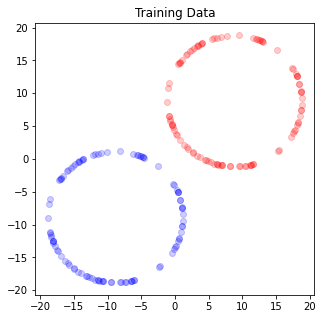

In [3]:
samples = 100
radius = 10
distance = 25

x_train,y_train = make_circles(radius,distance,samples)


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], alpha=0.2, c='red', label='class 1')
ax.scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], alpha=0.2, c='blue', label='class 0')
ax.set_title('Training Data')
plt.show()

In [4]:
# Deterministic model 

###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

###neural network model design choices
width = 4
hidden_layers = 3
input_dim = x_train.shape[1]
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': activation_fn_type,
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

In [5]:
###define design choices in gradient descent
params = {'step_size':1e-4, 
          'max_iteration':20000, 
          'random_restarts':1, 
          'check_point':500}
        
#fit my neural network to minimize Bernoulli lklh on the given data
nn.fit(x_train.T, y_train.reshape((1,-1)), params, reg_param = 0.0002)

Iteration 0 lower bound 5997.797910853184; gradient mag: 10284.113835993356
Iteration 500 lower bound 4092.7306019090793; gradient mag: 8803.336982497069
Iteration 1000 lower bound 2084.055467295086; gradient mag: 8038.568605455433
Iteration 1500 lower bound 587.9490069950004; gradient mag: 4363.921870654623
Iteration 2000 lower bound 278.0045890208442; gradient mag: 1861.468117802728
Iteration 2500 lower bound 183.3149351593949; gradient mag: 1476.8023041520937
Iteration 3000 lower bound 81.40782014745017; gradient mag: 813.1768125450942
Iteration 3500 lower bound 58.004773563041006; gradient mag: 444.18039261370666
Iteration 4000 lower bound 45.36052445886508; gradient mag: 260.0686444014573
Iteration 4500 lower bound 38.86797336723813; gradient mag: 159.52636094027807
Iteration 5000 lower bound 33.52319898346826; gradient mag: 123.10642055187166
Iteration 5500 lower bound 30.24348898937723; gradient mag: 86.46452781010565
Iteration 6000 lower bound 27.23807724882658; gradient mag: 6

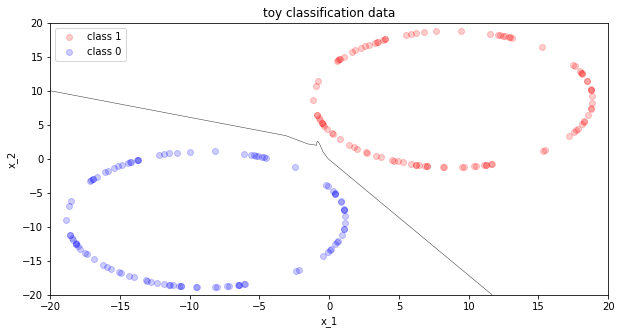

In [6]:
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], alpha=0.2, c='red', label='class 1')
ax.scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], alpha=0.2, c='blue', label='class 0')
plot_decision_boundary(x_train, y_train, [nn], ax, poly_degree=1, shaded=False, interval = np.arange(-20,20,.01))

ax.set_xlim((-20, 20))
ax.set_ylim((-20, 20))
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data')
ax.legend(loc='best')
plt.show()

### Deep Ensemble

In [7]:
# Deep ensemble
reg_param = 0.0002
random = np.random.RandomState(rand_state)
N_bootstrap = 20

# load existing data
if os.path.exists('data/high_dim_deep_ensemble0.pkl'):
    w_bootstrap = [] 
    nn_all = []
    for i in range(N_bootstrap):
        weights_here = pickle.load(open("data/high_dim_deep_ensemble" + str(i) + ".pkl", "rb"))
        w_bootstrap.append(weights_here)

        #set random state to make the experiments replicable
        rand_state = 0
        random = np.random.RandomState(rand_state)
        nn_here = Feedforward(architecture, random=random)
        nn_here.weights = weights_here
        nn_all.append(nn_here)

# if no existing data, do a new run
else: 
    nn_all, w_bootstrap = ensemble(x_train, y_train, Feedforward, architecture, params, random, N_bootstrap, reg_param)
    
    # save data 
    masterdir = os.getcwd()
    for (i,nn) in enumerate(nn_all):
        with open('data/high_dim_deep_ensemble' + str(i) + '.pkl', 'wb') as f:
            pickle.dump(nn.weights, f, pickle.HIGHEST_PROTOCOL)

# MC DROPOUT

In [8]:
# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

width = 4
hidden_layers = 3
input_dim = x_train.shape[1]
output_dim = 1

architecture_dropout = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'dropout_rate': 0.1,
               'activation_fn_type': activation_fn_type,
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#instantiate a Feedforward neural network object
nn_dropout = Feedforward_Dropout(architecture_dropout, random=random)

params = {'step_size':1e-3, 
          'max_iteration':10000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn_dropout.fit(x_train.T, y_train.reshape((1,-1)), params, reg_param = .001)

Iteration 0 lower bound 6042.221284679286; gradient mag: 10196.824361806144
Iteration 500 lower bound 102.5603325728883; gradient mag: 865.2866137978967
Iteration 1000 lower bound 102.33695476274465; gradient mag: 52.198934801990546
Iteration 1500 lower bound 49.44427488670344; gradient mag: 37.01266968556687
Iteration 2000 lower bound 54.53673873441791; gradient mag: 41.24656923609767
Iteration 2500 lower bound 30.258184654061115; gradient mag: 32.391374221515626
Iteration 3000 lower bound 70.64415900902137; gradient mag: 49.95102982342333
Iteration 3500 lower bound 97.51407970689974; gradient mag: 54.48428479259052
Iteration 4000 lower bound 19.974063660070815; gradient mag: 68.22209784078373
Iteration 4500 lower bound 84.671739049428; gradient mag: 25.321655891093148
Iteration 5000 lower bound 8.017572684781785; gradient mag: 10.097088403201063
Iteration 5500 lower bound 7.054238281230382; gradient mag: 22.703241599203263
Iteration 6000 lower bound 69.94721764331365; gradient mag: 2

# BBVI

In [9]:
S = 20
max_iteration = 9000
step_size = 1e-3

Sigma_W = np.eye(nn.D)*5
sigma_y = 1

variational_params = variational_inference(Sigma_W, sigma_y, y_train, x_train.T, nn, nn.forward, S, max_iteration, step_size, 1)

Optimizing variational parameters...
Iteration 0 lower bound -594.1241869001293; gradient mag: 7.716027244495168
Iteration 100 lower bound -587.6386345286309; gradient mag: 7.683874960938349
Iteration 200 lower bound -581.3101686200753; gradient mag: 7.6642574220645425
Iteration 300 lower bound -575.0790759540628; gradient mag: 7.647887681861037
Iteration 400 lower bound -568.9233884365001; gradient mag: 7.634480961455361
Iteration 500 lower bound -562.8268778035224; gradient mag: 7.622930083179151
Iteration 600 lower bound -556.780487668695; gradient mag: 7.612932592667476
Iteration 700 lower bound -550.7780996552351; gradient mag: 7.603992198623289
Iteration 800 lower bound -544.8145740998183; gradient mag: 7.596255470829896
Iteration 900 lower bound -538.8855756005768; gradient mag: 7.5892425252777915
Iteration 1000 lower bound -532.9872237563501; gradient mag: 7.583208955789904
Iteration 1100 lower bound -527.1156959893133; gradient mag: 7.57830496632015
Iteration 1200 lower bound 

In [10]:
var_means = variational_params[0:nn.D]
var_variance = np.exp(variational_params[nn.D:])**2

x_test, y_test = make_circles(radius,distance,samples)
posterior_sample_size = 100
posterior_samples = np.random.multivariate_normal(var_means, np.diag(var_variance), size=posterior_sample_size)
y_predict_noiseless = nn.forward(posterior_samples, x_test.T)
y_predict_noiseless = np.squeeze(y_predict_noiseless)

nn_list = []
for i in range(posterior_sample_size):
    #set random state to make the experiments replicable
    rand_state = 0
    random = np.random.RandomState(rand_state)
    tempNN = Feedforward(architecture, random=random)
    tempNN.weights = np.random.multivariate_normal(var_means, np.diag(var_variance)).reshape((1,var_means.shape[0]))
    nn_list.append(tempNN)

/work/am207/baselines.py:686: UserWarning: No contour levels were found within the data range.
  if shaded:


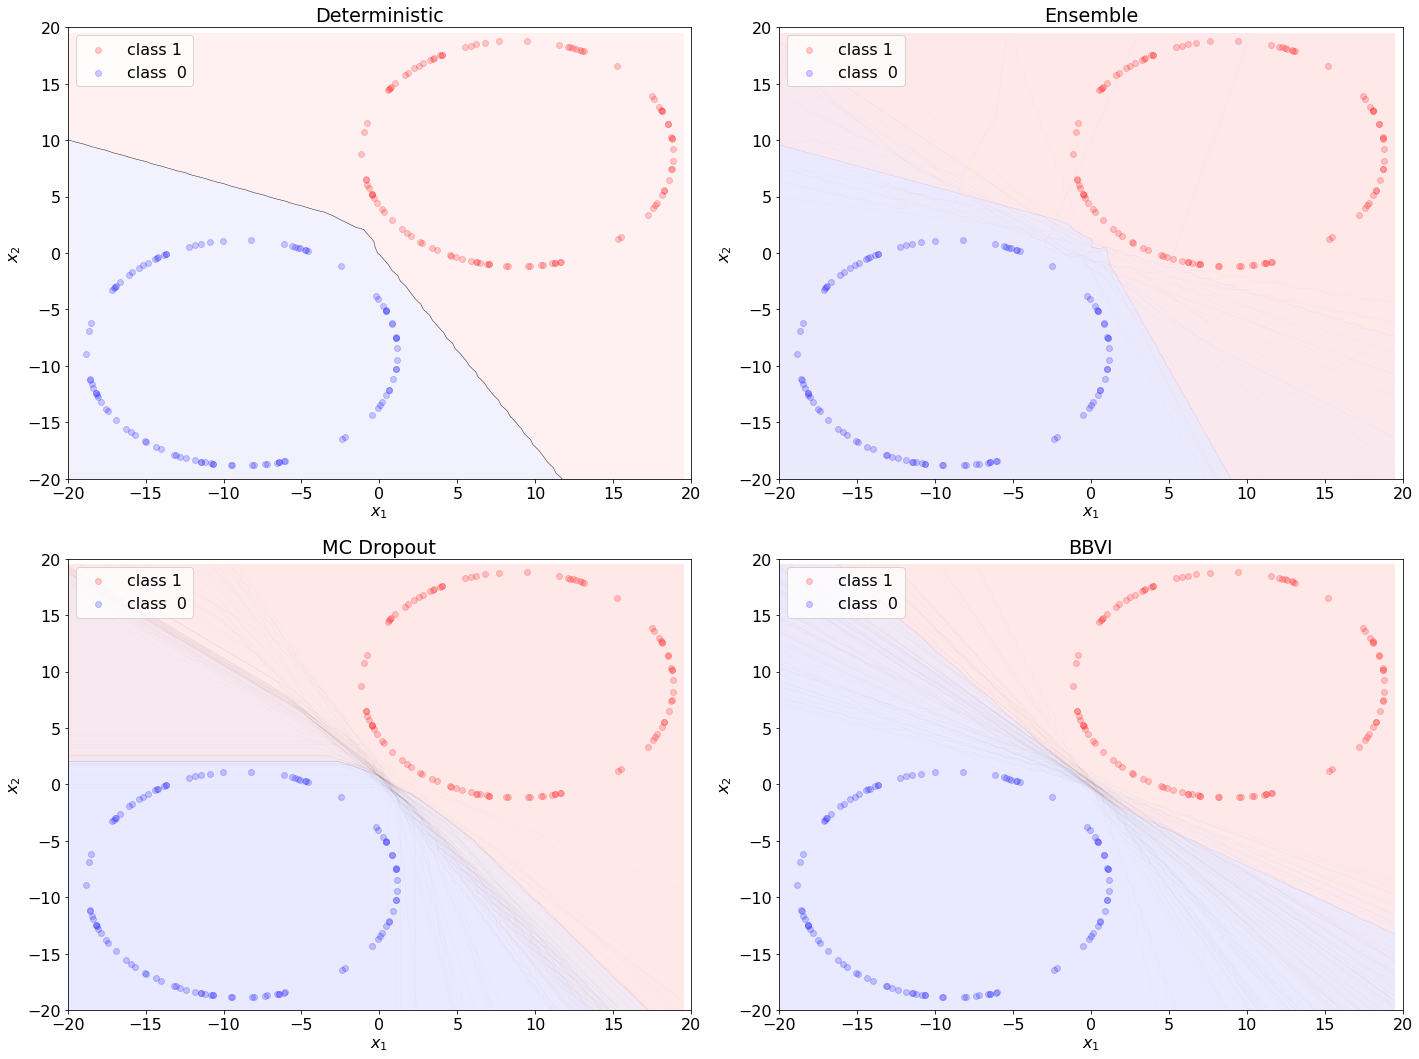

In [13]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
k = 0 
models = ['Deterministic', 'Ensemble', 'MC Dropout', 'BBVI']
for i in range(2):
    for j in range(2):
        
        ax[i][j].scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], alpha=0.2, c='red', label='class 1')
        ax[i][j].scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], alpha=0.2, c='blue', label='class  0')
        if k == 0: 
            nn_here = [nn]
        elif k == 1: 
            nn_here = nn_all 
        elif k == 2: 
            nn_here = [nn_dropout]*100
        elif k == 3: 
            nn_here = nn_list
        plot_decision_boundary(x_train, y_train, nn_here, ax[i][j], poly_degree=1, shaded=True,interval = np.arange(-20,20,0.5))
        ax[i][j].set_xlim((-20, 20))
        ax[i][j].set_ylim((-20, 20))
        ax[i][j].set_xlabel('$x_1$')
        ax[i][j].set_ylabel('$x_2$')
        ax[i][j].set_title(models[k])
        ax[i][j].legend(loc='best')
        k+= 1 
plt.tight_layout()
plt.show()

Notes: as distance goes to infintiy, the decision boundaries become straight lines. 

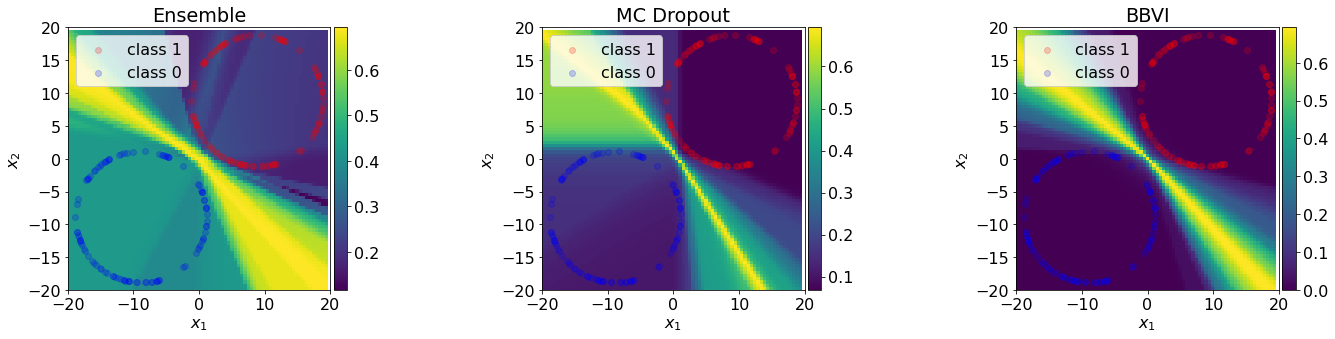

In [17]:
 
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
models = ['Ensemble', 'MC Dropout', 'BBVI']
for k in range(3):
    plt.rcParams.update({'font.size': 16})
    ax[k].scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], alpha=0.2, c='red', label='class 1')
    ax[k].scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], alpha=0.2, c='blue', label='class 0')
    if k == 0: 
        nn_here = nn_all 
        cl=plot_entropycontours(x_train, y_train, nn_here, w_bootstrap, ax[k], models[k], poly_degree=1, shaded=True, interval = np.arange(-20,20,0.5))
    
    elif k == 1:
        nn_here = nn_dropout
        weights_here = [nn_dropout.weights]*50
        cl=plot_entropycontours(x_train, y_train, nn_here, weights_here, ax[k], models[k], poly_degree=1, shaded=True,interval = np.arange(-20,20,0.5))

    elif k == 2: 
        nn_here = nn_list
        cl=plot_entropycontours(x_train, y_train, nn, [posterior_samples[i].reshape((1, -1)) for i in range(posterior_samples.shape[0])], ax[k], models[k], poly_degree=1, shaded=True, interval = np.arange(-20,20,0.5))
    
    divider = make_axes_locatable(ax[k])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(cl, cax=cax, orientation='vertical')
    ax[k].set_xlim((-20, 20))
    ax[k].set_ylim((-20, 20))
    ax[k].set_xlabel('$x_1$')
    ax[k].set_ylabel('$x_2$')
    ax[k].set_title(models[k])
    ax[k].legend(loc='best')
    
plt.tight_layout()
plt.show()

In [41]:
# define functions to calculate accuracy and referral rate

def accuracy_zoe(retain_perc, samples, n_run, N, x_test, y_test):
    auc_dropout = np.zeros([len(retain_perc),N])
    auc_det = np.zeros([len(retain_perc),N])
    auc_ens = np.zeros([len(retain_perc),N])
    auc_bbvi = np.zeros([len(retain_perc),N])
    for (i, perc) in enumerate(retain_perc):
        for j in range(N):
            auc_dropout[i,j] = auc_calc(x_test, y_test, nn_dropout, N, perc, "mc")
            posterior_samples = np.random.multivariate_normal(var_means, np.diag(var_variance), size=posterior_sample_size)
            auc_bbvi[i,j] = auc_calc(x_test, y_test, nn, N, perc, "bbvi", weightlist=posterior_samples)

        auc_ens[i,:] = auc_calc(x_test, y_test, nn_all, 1, perc, "ensemble")

        # use sigmoid probability for retaining data
        auc_det[i,:] = auc_calc(x_test, y_test, nn, N, perc, "deterministic")

    return auc_det, auc_ens, auc_dropout, auc_bbvi


def accuracy(retain_perc, N, x_test, y_test):
    dropout_num=50
    auc_dropout = np.zeros([len(retain_perc),dropout_num])
    auc_det = np.zeros([len(retain_perc),N])
    auc_ens = np.zeros([len(retain_perc),len(w_bootstrap)])
    auc_bbvi = np.zeros([len(retain_perc),len(posterior_samples)])
    for (i, perc) in enumerate(retain_perc):
        auc_dropout[i,:] = auc_calc_beta(x_test, y_test, nn_dropout, dropout_num, perc, "mc") #all x, 1 perc, all w
        #posterior_samples = np.random.multivariate_normal(var_means, np.diag(var_variance), size=posterior_sample_size)
        auc_bbvi[i,:] = auc_calc_beta(x_test, y_test, nn, N, perc, "bbvi", weightlist=posterior_samples)
        ensi = auc_calc_beta(x_test, y_test, nn, N, perc, "ensemble", weightlist=w_bootstrap)
        auc_ens[i,:] = ensi #Changed to N
        #print (ensi)
        # use sigmoid probability for retaining data
        auc_det[i,:] = auc_calc_beta(x_test, y_test, nn, N, perc, "deterministic")
    return auc_det, auc_ens, auc_dropout, auc_bbvi

def accuracy_plot(auc_det, auc_ens, auc_dropout, auc_bbvi, x_train, y_train, x_test, y_test, retain_perc):

    auc_dropout_ub = np.percentile(auc_dropout, 97.5, axis=1)
    auc_dropout_lb = np.percentile(auc_dropout, 2.5, axis=1)

    auc_ub_ens = np.percentile(auc_ens, 97.5, axis=1)
    auc_lb_ens = np.percentile(auc_ens, 2.5, axis=1)

    auc_ub_bbvi = np.percentile(auc_bbvi, 97.5, axis=1)
    auc_lb_bbvi = np.percentile(auc_bbvi, 2.5, axis=1)
    
    plt.rcParams.update({'font.size': 16})
    fig,ax=plt.subplots(1,2,figsize=(20,5))
    ax[0].scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], alpha=0.2, c='red', label='class 1')
    ax[0].scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], alpha=0.2, c='blue', label='class 0')
    ax[0].scatter(x_test[y_test == 1, 0], x_test[y_test == 1, 1], alpha=0.8, c='blue', label='test class 1')
    ax[0].scatter(x_test[y_test == 0, 0], x_test[y_test == 0, 1], alpha=0.8, c='red', label='test class 0')
    ax[0].set_xlabel('$x_1$')
    ax[0].set_ylabel('$x_2$')
    ax[0].legend()
    ax[0].set_title('Visualization of training and test sets')
    ax[1].fill_between(retain_perc, auc_dropout_ub, auc_dropout_lb, color='blue', alpha=0.2)
    ax[1].plot(retain_perc, np.mean(auc_dropout,axis=1), 'blue', label='MC dropout')
    ax[1].plot(retain_perc, np.mean(auc_ens,axis=1), 'red', label='Ensemble')
    ax[1].plot(retain_perc, np.mean(auc_bbvi,axis=1), 'purple', label='BBVI')
    ax[1].plot(retain_perc, np.mean(auc_det,axis=1), 'green', label='Deterministic')
    ax[1].fill_between(retain_perc, auc_ub_bbvi, auc_lb_bbvi, color='purple', alpha=0.2)
    ax[1].fill_between(retain_perc, auc_ub_ens, auc_lb_ens, color='red', alpha=0.2)
    ax[1].set_xlabel("Retained Data")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_title("Accuracy of different models")
    ax[1].set_xlim((min(retain_perc), max(retain_perc)))
#     ax[1].set_ylim((30, 90))
    ax[1].legend()
    plt.show()


In [43]:
# Accuracy vs referral rate 
samples = 100
n_run = 100 # the number of times to call the NN for predicative entropy 
N = 100

class_0 = np.random.multivariate_normal([-10, -10], 25 * np.eye(2), samples)
class_1 = np.random.multivariate_normal([10, 10], 25 * np.eye(2), samples)
x_test = np.vstack((class_0, class_1))
y_test = np.array([0] * 100 + [1] * 100)

'''
epsilon = 5
radius = 10 + epsilon
distance = 25 + epsilon
x_test, y_test = make_circles(radius,distance,samples)
'''

retain_perc = np.linspace(0.2, 1, 10)

auc_det, auc_ens, auc_dropout, auc_bbvi = accuracy(retain_perc, N, x_test, y_test)

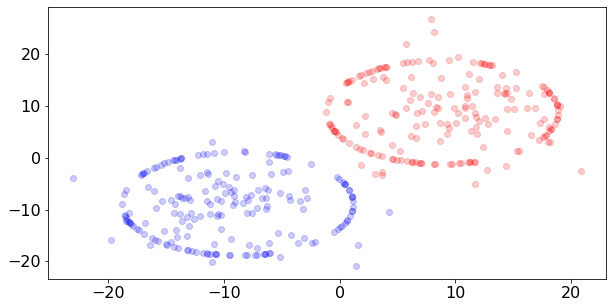

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], alpha=0.2, c='red', label='class 1')
ax.scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], alpha=0.2, c='blue', label='class 0')

'''
epsilon = 10
radius = 10  + epsilon
distance = 25 + epsilon
x_test, y_test = make_circles(radius,distance,samples)
'''

class_0 = np.random.multivariate_normal([-10, -10], 25 * np.eye(2), samples)
class_1 = np.random.multivariate_normal([10, 10], 25 * np.eye(2), samples)
x_test = np.vstack((class_0, class_1))
y_test = np.array([0] * 100 + [1] * 100)


ax.scatter(x_test[y_train == 1, 0], x_test[y_train == 1, 1], alpha=0.2, c='red', label='class 1')
ax.scatter(x_test[y_train == 0, 0], x_test[y_train == 0, 1], alpha=0.2, c='blue', label='class 0')

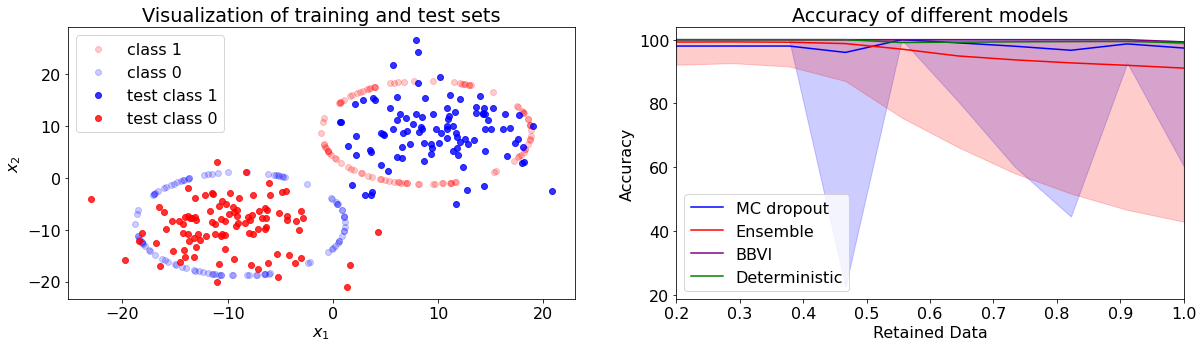

In [45]:
accuracy_plot(auc_det, auc_ens, auc_dropout, auc_bbvi, x_train, y_train, x_test, y_test, retain_perc)